# Data Cleaning

This notebook focuses on cleaning and preparing the data for vectorization and modeling.

* Cleaning & creating tokens using lemmatization
* Token Analysis
* Rare & common word analysis
* Removing custom stopwords
* Splitting the data in train and test set and saving processed data. This ensures all models are trained and evaluated on the same cleaned data.

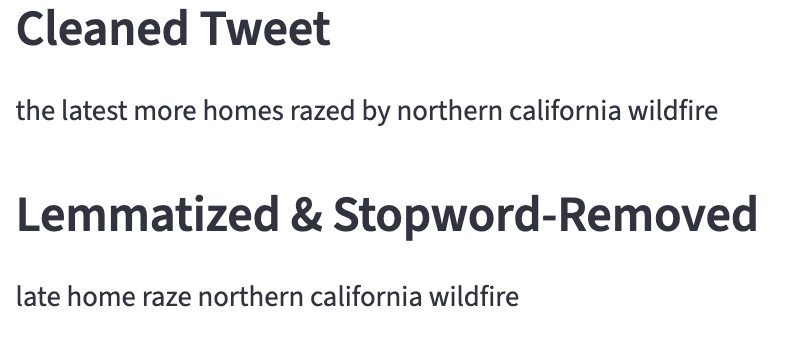

# Environment & Data

This section covers all the imports like libraries and data.

In [21]:
# Standard 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import pickle

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [22]:
# File and Path Management
import sys, os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data_visualization import plot_wordcloud, plot_top_words
from src.data_cleaning import clean_text, tokenize_and_remove_stopwords


In [23]:
# Setting up visualization aesthetics
sns.set_palette("Set2")
sns.set(style="whitegrid")

In [24]:
# Load the dataset
df_tweets = pd.read_csv('/Users/didodeboodt/Documents/Projects/NLP_Tweet_Disaster_Classifier/data/raw/full_data.csv')

In [25]:
# Look at the first few rows 
df_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Cleaning and Tokenization

We start by cleaning our data using the funcion we created that cleans and lemmatizes. We add a column to the DataFrame `clean_text`.

* Lowercasing
* Normalization and accent removal with unicodeta library (ü, ö, etc)
* Removing hyper links (https://)
* Removing mentions (@)
* Removing hashtags (#)
* Removing digits
* Removing extra whitespace (leading and trailing)
* Removing words that are only 1 character
* Returns clean text

Next we tokenize and remove stop words with the cleaning function that we created. We add a new column to the DataFrama `tokens`.

* word_tokenize is applied to remove english stopwords.
* Tagged tokens are defined with POS
* Tokens are lemmatized and stopwords are filtered out
* Returns tokens

Then we join the tokens back together and add them as a new column `joined_tokens`to the DataFrame.

In [26]:
# Clean text data
df_tweets['clean_text'] = df_tweets['text'].apply(clean_text)

# Tokenize and remove stop words
df_tweets['tokens'] = df_tweets['clean_text'].apply(tokenize_and_remove_stopwords)

# Join tokens for vectoriation
df_tweets['joined_tokens'] = df_tweets['tokens'].apply(lambda x: ' '.join(x))

In [27]:
# Look at the first rows of the data
df_tweets.head()

,id,keyword,location,text,target,clean_text,tokens,joined_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,"[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfire pour...


# Token Analysis

Here we analyze our tokens to look for comen words, rare words, and words that could be removed as stopwords.

* We define disaster and non-disaster Tweets and their tokens so we can visualize the top 10 tokens by frequency for both classes.

* Then we created a wordcloud for each class to get a sense of tokens that might stick out.

* We look at the top 30 tokens and look at words that only appear once in all the tweets.

* Next we define our custom stopwords, remove them from the data, and visualize the tokens again to compare the results.

In [28]:
# define disaster and non-disaster tweets
disaster_tweets = df_tweets[df_tweets['target'] == 1]
non_disaster_tweets = df_tweets[df_tweets['target'] == 0]

# define disaster and non-disaster tokens
disaster_tweets_tokens = [token for tokens in disaster_tweets['tokens'] for token in tokens]
non_disaster_tweets_tokens = [token for tokens in non_disaster_tweets['tokens'] for token in tokens]

# Count word frequencies
disaster_tweets_word_freq = Counter(disaster_tweets_tokens)
non_disaster_tweets_word_freq = Counter(non_disaster_tweets_tokens)

# Get top 10 words for disaster and non-disaster tweets
disaster_tweets_top_words = dict(disaster_tweets_word_freq.most_common(10))
non_disaster_tweets_top_words = dict(non_disaster_tweets_word_freq.most_common(10))

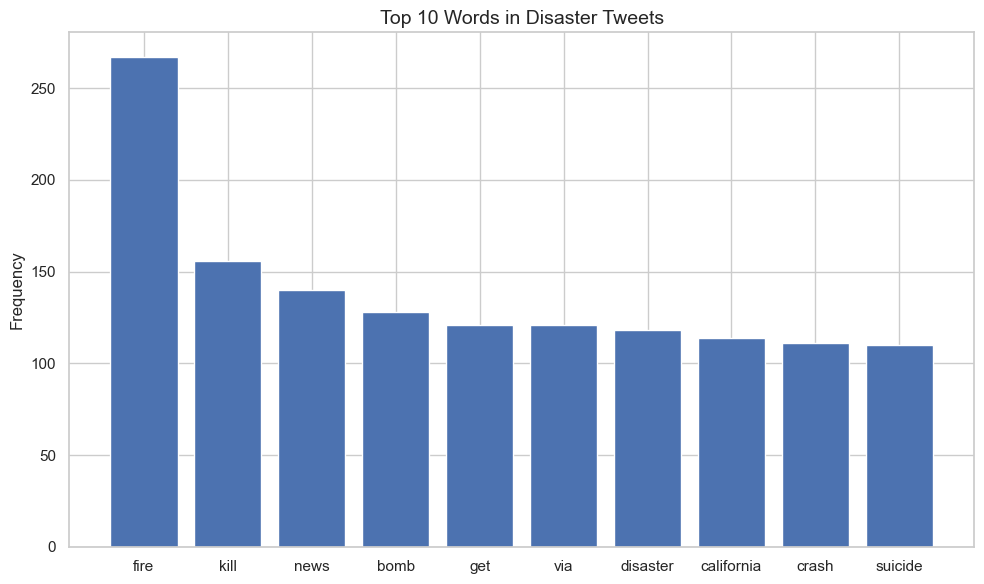

In [29]:
# Plotting the top words in disaster tweets
plot_top_words(disaster_tweets_tokens, n=10, title="Top 10 Words in Disaster Tweets")

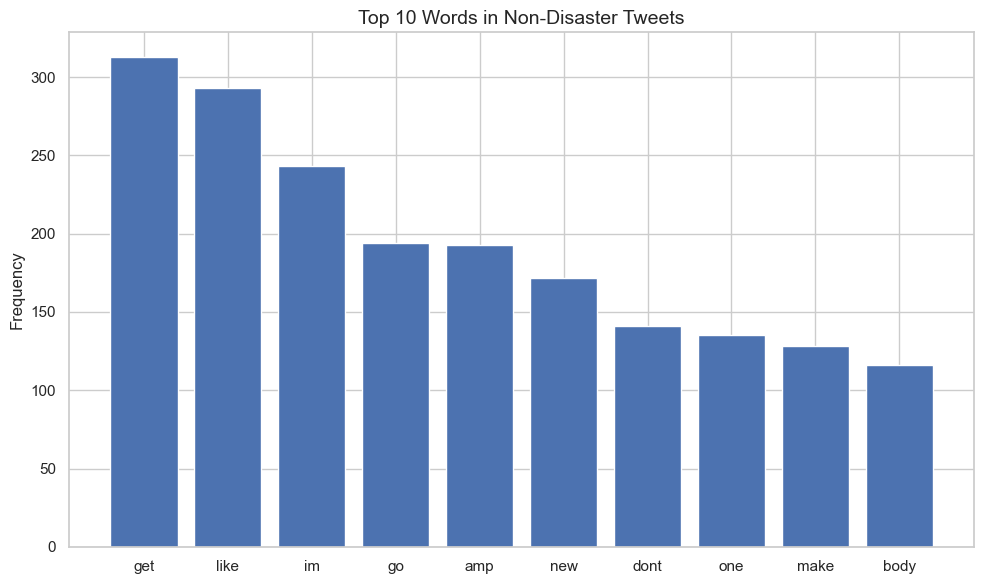

In [30]:
# Plotting the top words in non-disaster tweets
plot_top_words(non_disaster_tweets_tokens, n=10,title="Top 10 Words in Non-Disaster Tweets")

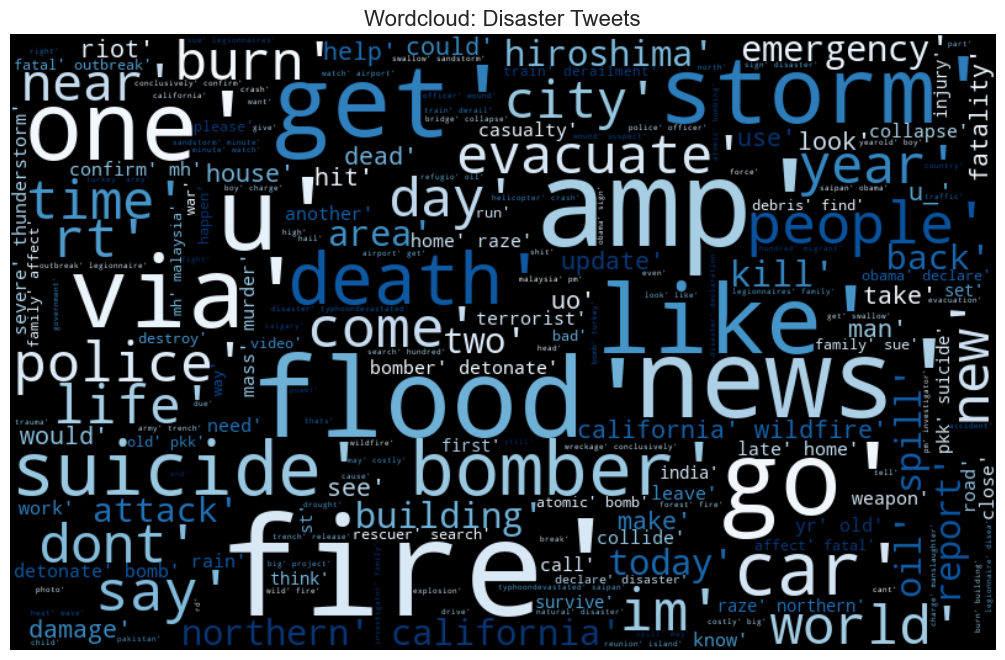

In [31]:
# Plotting wordcloud for disaster tweets
plot_wordcloud(disaster_tweets_tokens, title="Wordcloud: Disaster Tweets")

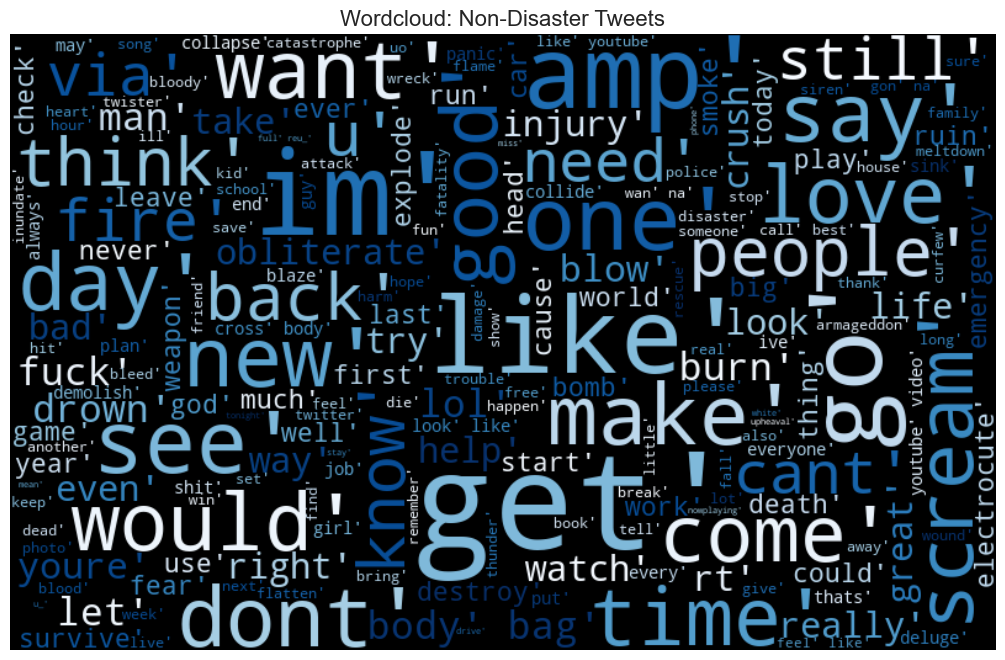

In [32]:
# Plotting wordcloud for non-disaster tweets
plot_wordcloud(non_disaster_tweets_tokens, title="Wordcloud: Non-Disaster Tweets")

# Rare and Common Words

We will count the words and see which are most common and which are rare. This can help us find common stop words for this data that we can consider removing.

In [33]:
# Count all tokens for overall word frequency analysis
all_tokens = [token for tokens in df_tweets['tokens'] for token in tokens]
word_freq = Counter(all_tokens)

# Top 30 most frequent
common_words = word_freq.most_common(30)
pd.DataFrame(common_words, columns=['Word', 'Count']).head(30)

,Word,Count
0,get,434
1,like,392
2,fire,357
3,amp,300
4,im,299
5,go,275
6,new,230
7,via,220
8,one,204
9,people,199


In [34]:
# Words that appear only once
rare_words = [word for word, count in word_freq.items() if count == 1]
print(f"{len(rare_words)} words appear only once")

9574 words appear only once


# Remove Custom Stop Words

We will define our custom stop words below based on the Token Analysis. Next we will visualize the newly filtered tokens.

In [35]:
# Define custom stopwords based on analysis
custom_stopwords = {
    'im', 'get', 'like', 'go', 'u', 'via', 'one', 'people', 'say', 'dont',
    'make', 'time', 'come', '2', 'see', 'amp', 'news'
}

# Remove custom stopwords from tokens
df_tweets['tokens_filtered'] = df_tweets['tokens'].apply(lambda x: [w for w in x if w not in custom_stopwords])
df_tweets['joined_filtered_tokens'] = df_tweets['tokens_filtered'].apply(lambda x: ' '.join(x))

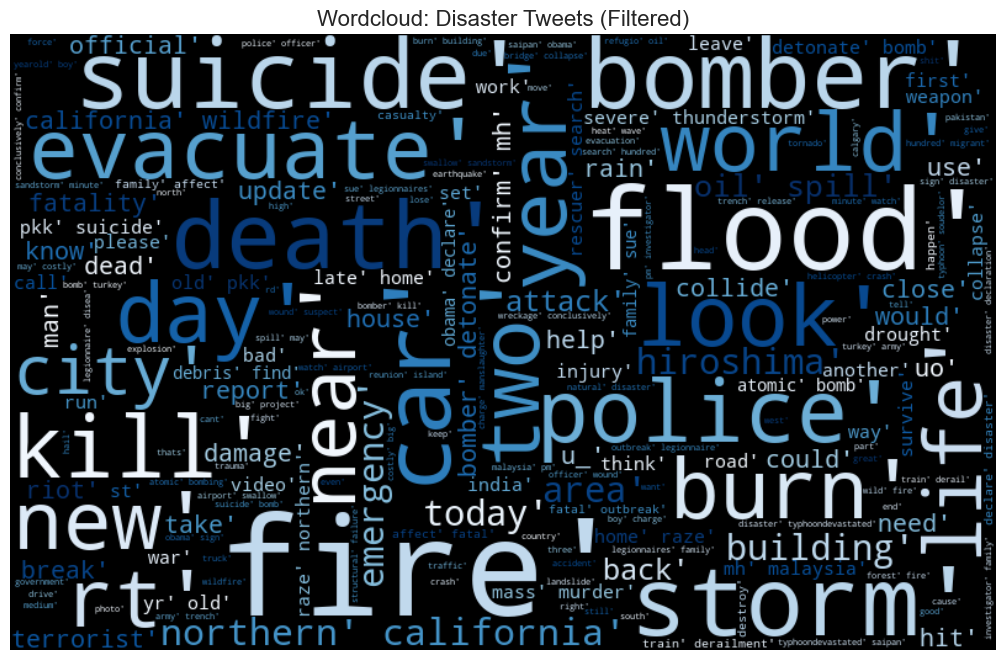

In [36]:
# Visualize disaster words after removing custom stopwords
disaster_tweets_filtered = df_tweets[df_tweets['target'] == 1]
disaster_tweets_filtered_tokens = [token for tokens in disaster_tweets_filtered['tokens_filtered'] for token in tokens]

plot_wordcloud(disaster_tweets_filtered_tokens, title="Wordcloud: Disaster Tweets (Filtered)")

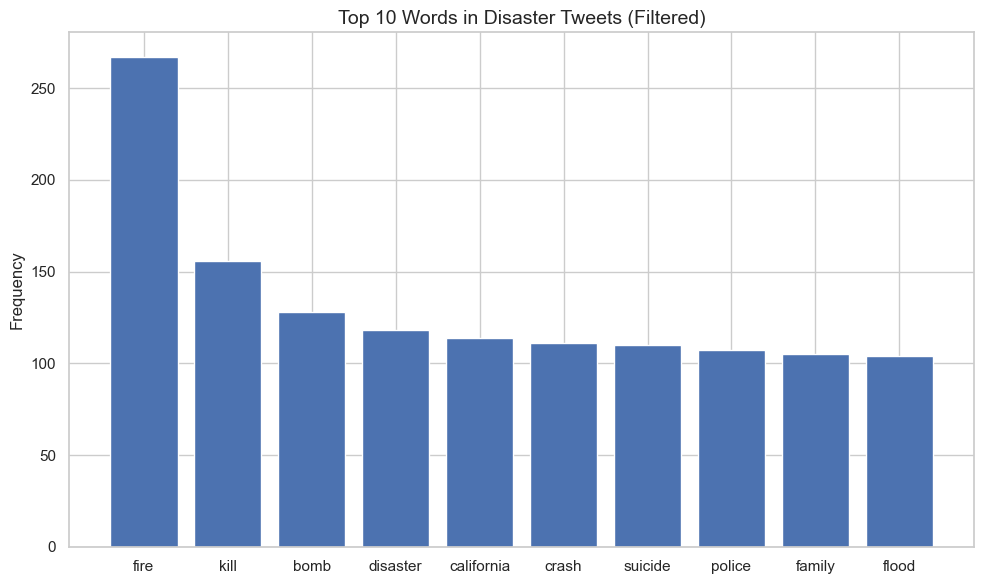

In [37]:
# Visualize non-disaster words after removing custom stopwords
plot_top_words(disaster_tweets_filtered_tokens, n=10, title="Top 10 Words in Disaster Tweets (Filtered)")

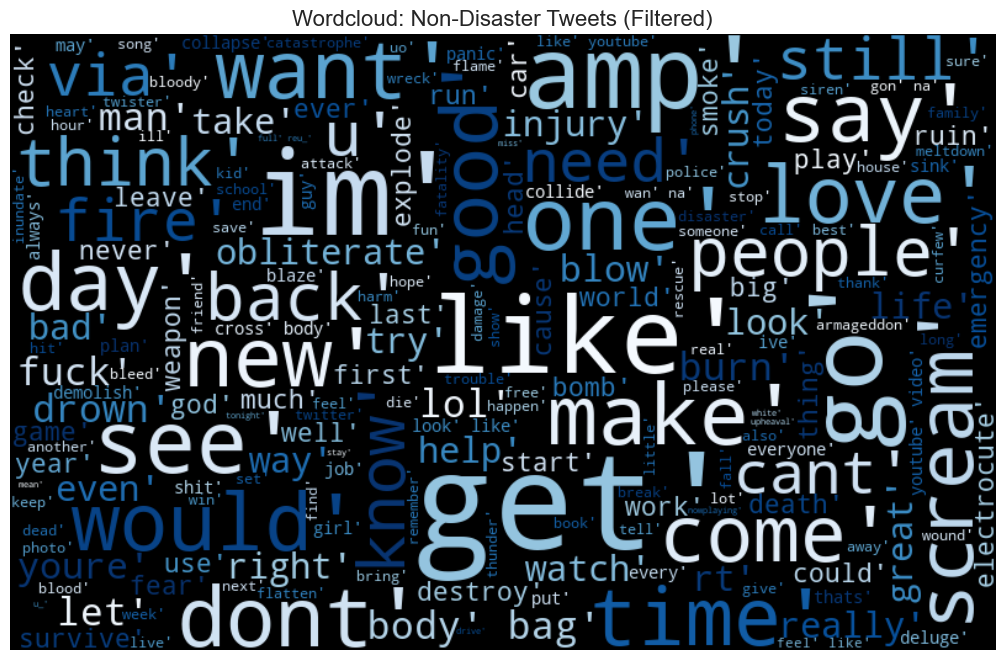

In [38]:
# Visualize non-disaster words after removing custom stopwords
non_disaster_tweets_filtered = df_tweets[df_tweets['target'] == 0]
non_disaster_tweets_filtered_tokens = [token for tokens in non_disaster_tweets_filtered['tokens_filtered'] for token in tokens]

plot_wordcloud(non_disaster_tweets_tokens, title="Wordcloud: Non-Disaster Tweets (Filtered)")

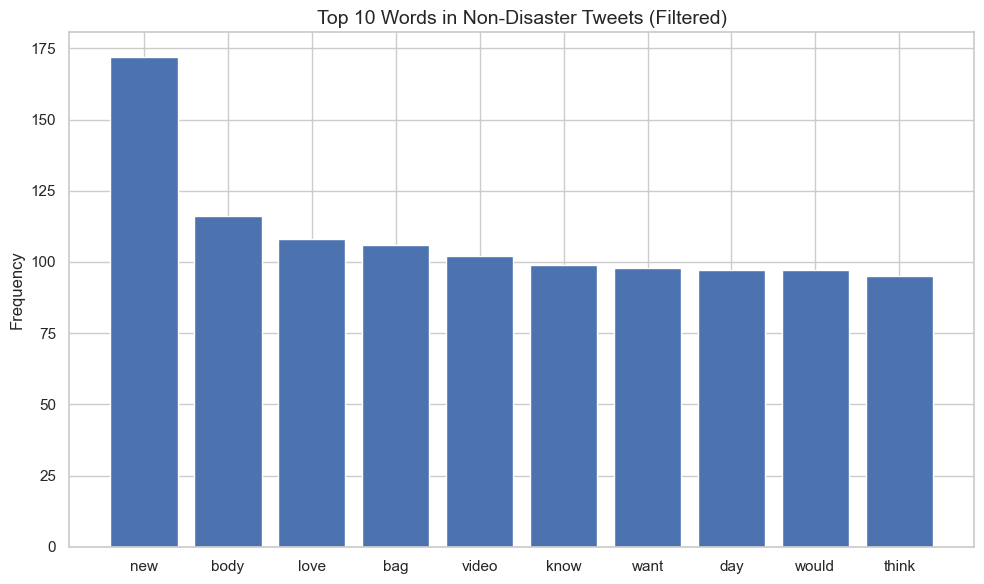

In [39]:
# Visualize non-disaster words after removing custom stopwords
plot_top_words(non_disaster_tweets_filtered_tokens, n=10, title="Top 10 Words in Non-Disaster Tweets (Filtered)")

# Split train and test set

Here we split the cleaned and lemmatized data in train and test set. We will save this to ensure all models are trained on the same split for fair comparison.

In [40]:
# Split target and features
X = df_tweets['clean_text']
y = df_tweets['target']

# FIXED split with random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

# Save them
with open('../data/processed/X_train_clean.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('../data/processed/X_test_clean.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('../data/processed/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

with open('../data/processed/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)